# ROC curves

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import numpy as np
import pandas as pd
import upath
import extras

loading extras module


In [3]:
path_root = upath.UPath("gs://liulab/differential_composition_and_expression/20230317_06h00m45s")
# print(extras.get_parquet_paths(path_root))
# !gsutil ls "{path_root}/*"

In [4]:
df_gene_stats = extras.load_gene_stats(path_root)

In [5]:
df_gene_stats

pval  \
origin               malignant_means log2_fc run_id gene_symbol gene_perturbed             
bulk                 0.55,0.85       -1.50   00     A1BG        False           0.980750   
                                                    A2M         False           0.597932   
                                                    A2ML1       False           0.021894   
                                                    A4GALT      False           0.000002   
                                                    A4GNT       False           0.533327   
...                                                                                  ...   
malignant_cibersortx 0.85,0.55       1.50    01     ZYG11A      False           0.080536   
                                                    ZYG11B      False           0.364652   
                                                    ZYX         False           0.003208   
                                                    ZZEF1       False           0.228987   
                                                    ZZZ3        False           0.425893   

                                                                                fold_change  \
origin               malignant_means log2_fc run_id gene_symbol gene_perturbed                
bulk                 0.55,0.85       -1.50   00     A1BG        False              1.221323   
                                                    A2M         False              1.036208   
                                                    A2ML1       False              0.843302   
                                                    A4GALT      False              0.253852   
                                                    A4GNT       False              0.940686   
...                                                                                     ...   
malignant_cibersortx 0.85,0.55       1.50    01     ZYG11A      False              1.131557   
                                                    ZYG11B      False              1.072175   
                                                    ZYX         False              1.322027   
                                                    ZZEF1       False              1.128114   
                                                    ZZZ3        False              1.102399   

                                                                                sparsity_overall  \
origin               malignant_means log2_fc run_id gene_symbol gene_perturbed                     
bulk                 0.55,0.85       -1.50   00     A1BG        False                       0.00   
                                                    A2M         False                       0.00   
                                                    A2ML1       False                       0.00   
                                                    A4GALT      False                       0.06   
                                                    A4GNT       False                       0.88   
...                                                                                          ...   
malignant_cibersortx 0.85,0.55       1.50    01     ZYG11A      False                       0.00   
                                                    ZYG11B      False                       0.00   
                                                    ZYX         False                       0.00   
                                                    ZZEF1       False                       0.00   
                                                    ZZZ3        False                       0.00   

                                                                                -log10_pval  \
origin               malignant_means log2_fc run_id gene_symbol gene_perturbed                
bulk                 0.55,0.85       -1.50   00     A1BG        False              0.008442   
                                                    A2M         F

## ROC (TPR, FPR)

In [7]:
import seaborn as sns


cm = sns.light_palette("green", as_cmap=True)


def mean_and_stddev(series: pd.Series):
    mean = series.mean()
    stddev = series.std()
    return f"{mean:4.2f}±{stddev:4.2f}"

In [8]:
df = df_gene_stats.xs("malignant_cibersortx", level="origin", drop_level=False)
print(df.groupby(["origin", "run_id"]).size())

origin                run_id
malignant_cibersortx  00        899528
                      01        899528
                      02        722835
dtype: int64


In [10]:
df_roc_curves, df_roc_auc_scores = extras.calculate_roc(df)

loading extras module


/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [11]:
(
    df_roc_auc_scores.groupby(["malignant_means", "log2_fc"])
    # .agg(func=mean_and_stddev)
    .mean().unstack("log2_fc")
).style.background_gradient(cmap='Reds_r', axis=None, vmin=0., vmax=1.)

log2_fc,-1.50,-1.00,-0.50,0.00,0.50,1.00,1.50
malignant_means,,,,,,,
"0.55,0.85",0.963298,0.927366,0.782276,nan,0.748794,0.870381,0.915191
"0.65,0.75",0.959868,0.919103,0.841029,nan,0.790537,0.901500,0.948228
"0.7,0.72",0.944273,0.915646,0.808769,nan,0.810092,0.932327,0.961219
"0.71,0.71",0.936970,0.916436,0.773039,nan,0.813008,0.909620,0.943646
"None,None",0.960730,0.922139,0.820695,nan,0.855143,0.906039,0.969469
"0.72,0.7",0.932170,0.912146,0.793881,nan,0.799238,0.926537,0.964619
"0.75,0.65",0.914284,0.868908,0.789106,nan,0.824476,0.908323,0.944384
"0.85,0.55",0.788613,0.808898,0.681025,nan,0.744550,0.812521,0.910807


In [12]:
(
    df_roc_auc_scores.groupby(["malignant_means", "log2_fc"])
    .agg(func=mean_and_stddev)
    .unstack("log2_fc")
).style.background_gradient(cmap=cm)

log2_fc,-1.50,-1.00,-0.50,0.00,0.50,1.00,1.50
malignant_means,,,,,,,
"0.55,0.85",0.96±0.01,0.93±0.02,0.78±0.01,nan± nan,0.75±0.05,0.87±0.03,0.92±0.02
"0.65,0.75",0.96±0.00,0.92±0.02,0.84±0.03,nan± nan,0.79±0.01,0.90±0.02,0.95±0.01
"0.7,0.72",0.94±0.01,0.92±0.02,0.81±0.02,nan± nan,0.81±0.01,0.93±0.01,0.96±0.01
"0.71,0.71",0.94±0.02,0.92±0.01,0.77±0.03,nan± nan,0.81±0.02,0.91±0.02,0.94±0.01
"None,None",0.96±0.01,0.92±0.01,0.82±0.04,nan± nan,0.86±0.03,0.91±0.02,0.97±0.01
"0.72,0.7",0.93±0.01,0.91±0.02,0.79±0.04,nan± nan,0.80±0.03,0.93±0.02,0.96±0.01
"0.75,0.65",0.91±0.04,0.87±0.03,0.79±0.00,nan± nan,0.82±0.03,0.91±0.01,0.94±0.00
"0.85,0.55",0.79±0.04,0.81±0.04,0.68±0.02,nan± nan,0.74±0.05,0.81±0.01,0.91±0.04


In [13]:
fig = extras.plot_roc(df_roc_curves)

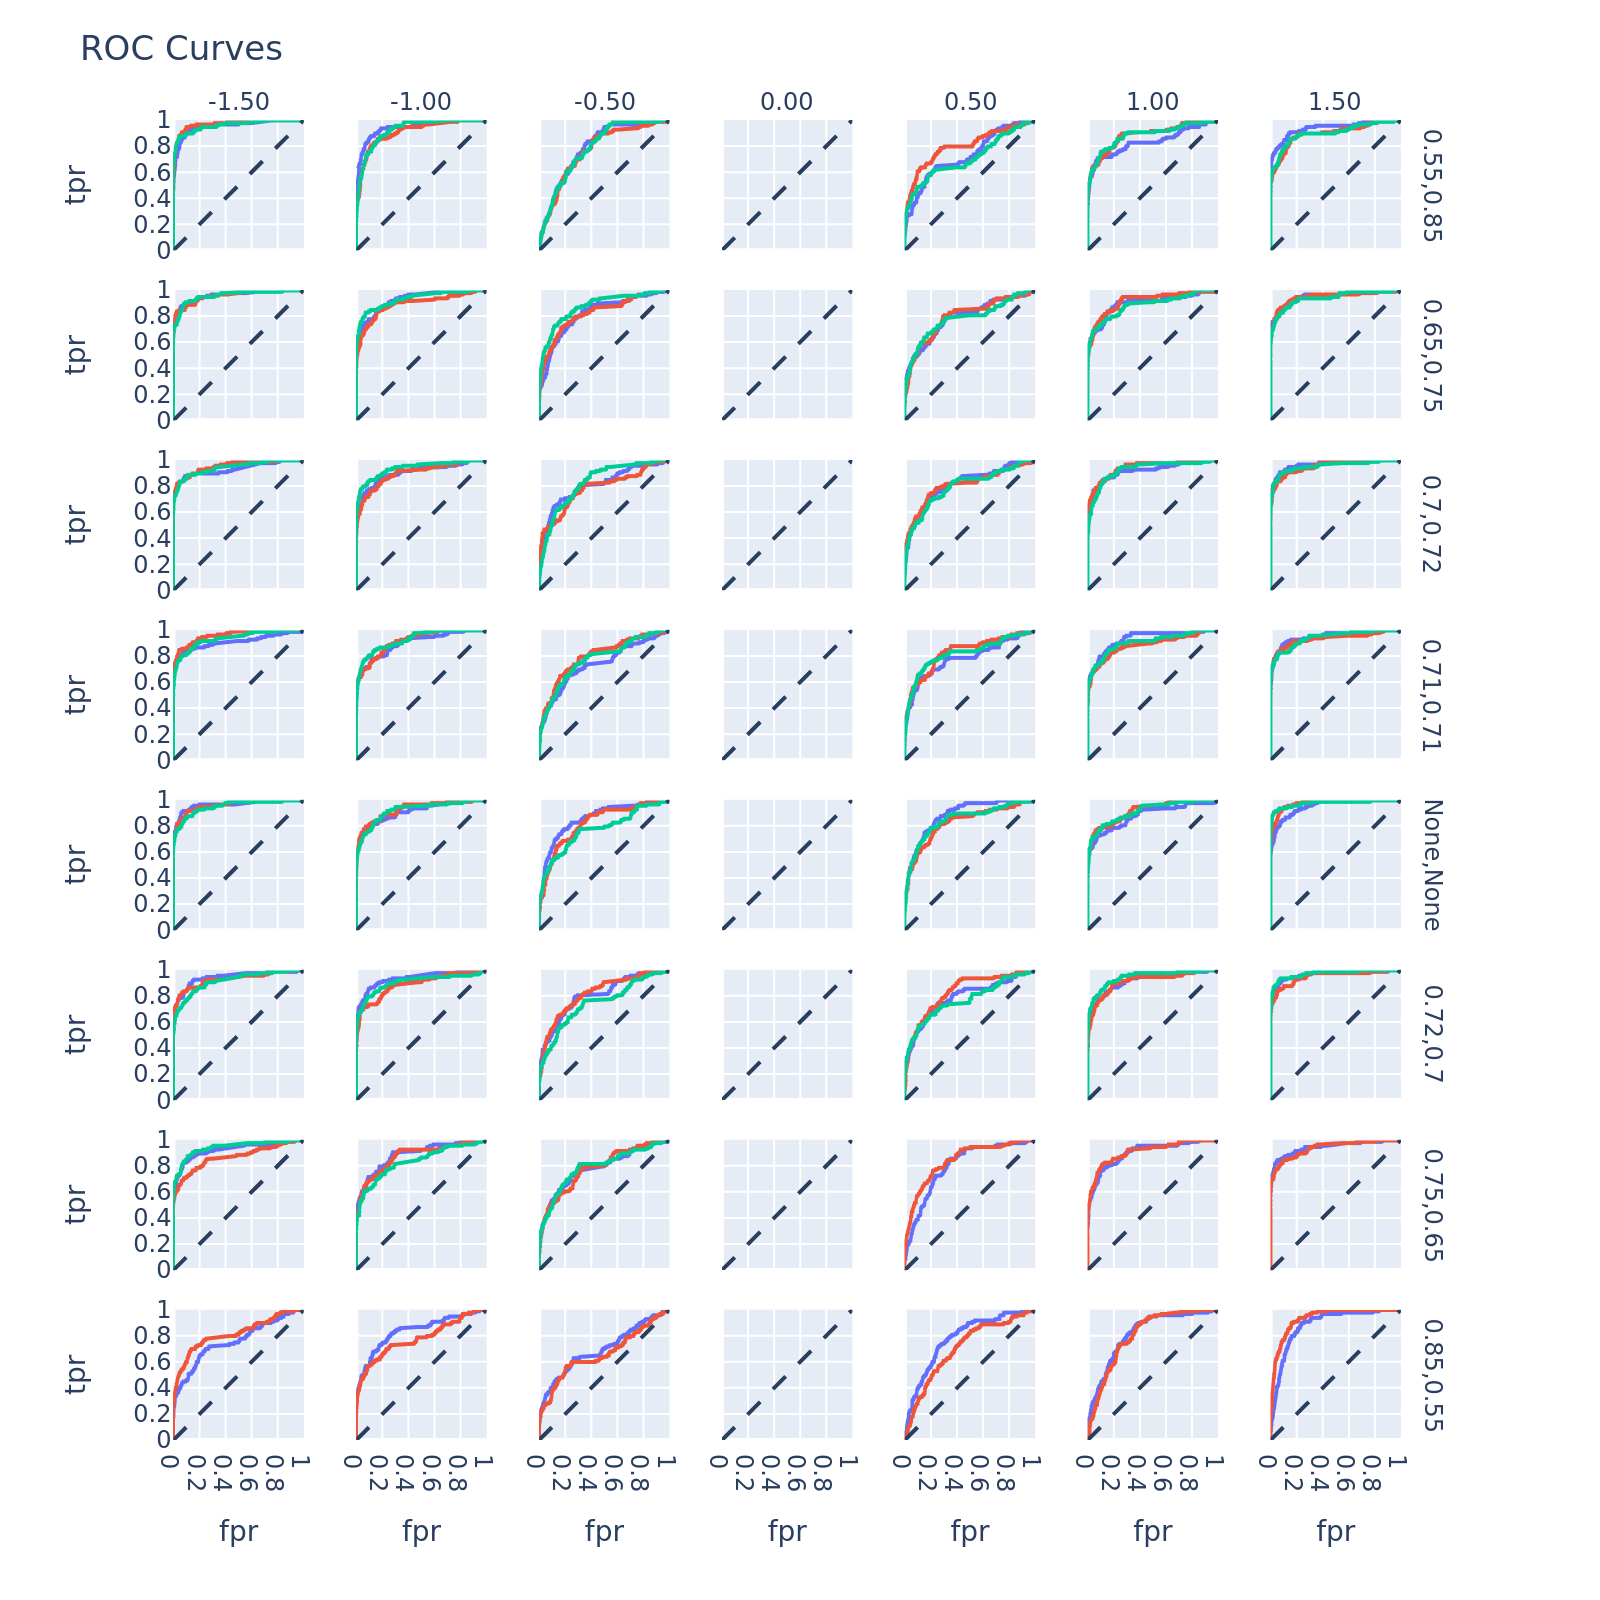

In [14]:
fig.update_layout(width=800, height=800)
fig.show(renderer="png", scale=2)

In [15]:
df_to_plot = (
    df_roc_curves
    .xs(slice("0.65,0.75", None, 3), level="malignant_means", drop_level=False)
    .xs(slice("-0.50", "0.50"), level="log2_fc", drop_level=False)
)
fig = extras.plot_roc(df_to_plot)

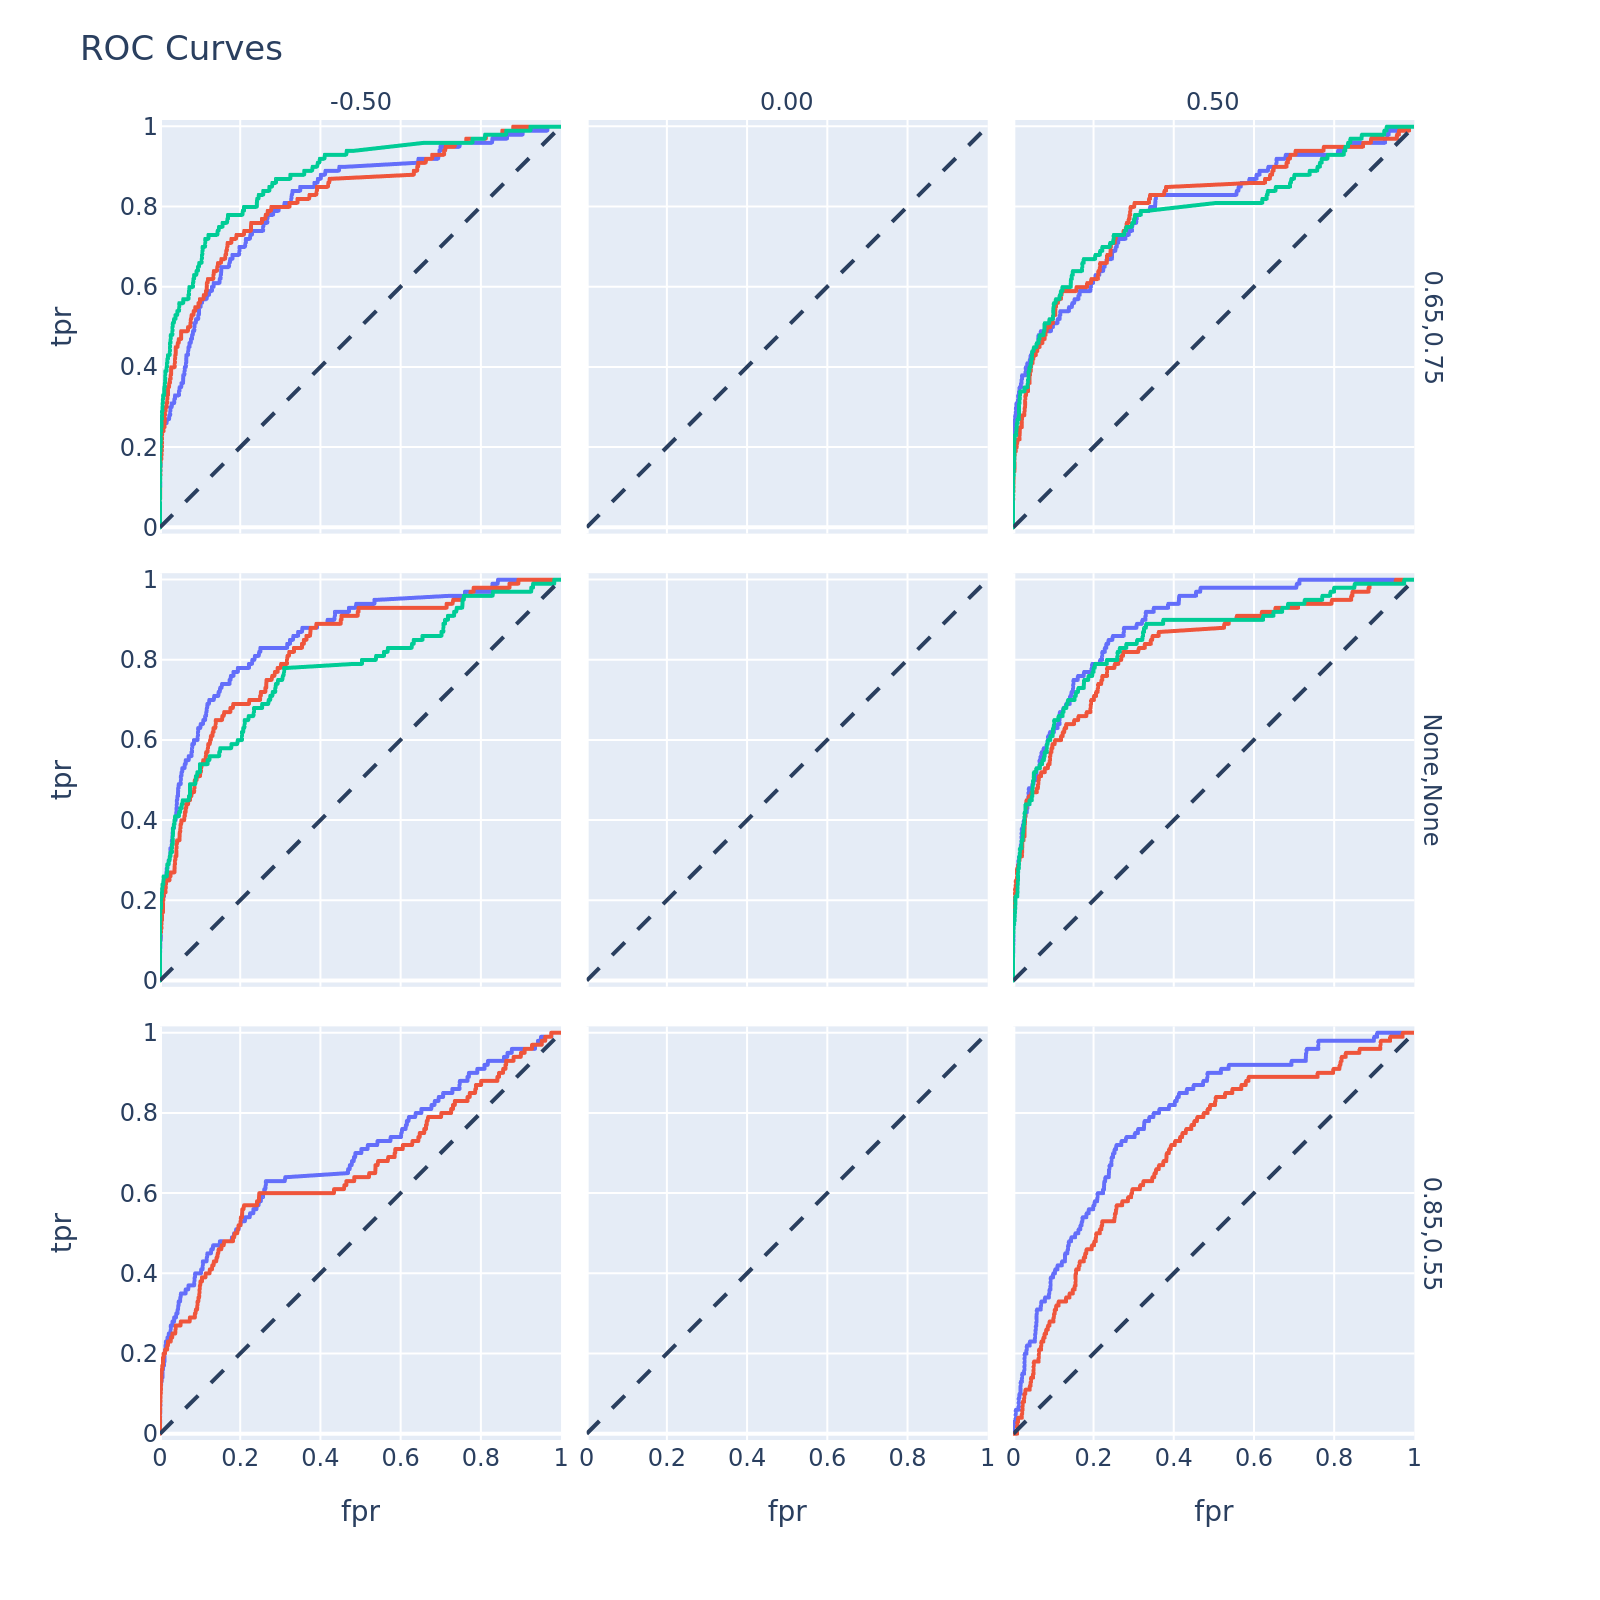

In [16]:
fig.update_layout(width=800, height=800)
fig.show(renderer="png", scale=2)

## precision and recall

In [17]:
df_prc_curves = extras.calculate_precision_and_recall(df)
df_prc_curves

/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class found in y_true, recall is set to one for all thresholds.

/opt/conda/envs/deconv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning:

No positive class fou

precision  recall  thresholds
malignant_means log2_fc run_id                                    
0.55,0.85       -1.50   00     0      0.006225    1.00   -4.900218
                               1      0.006226    1.00   -4.550631
                               2      0.006226    1.00   -3.855044
                               3      0.006227    1.00   -3.734957
                               4      0.006227    1.00   -3.652061
...                                        ...     ...         ...
0.85,0.55       1.50    01     6756   1.000000    0.04   12.156421
                               6757   1.000000    0.03   12.687826
                               6758   1.000000    0.02   13.253804
                               6759   1.000000    0.01   13.553128
                               6760   1.000000    0.00         inf

[963528 rows x 3 columns]

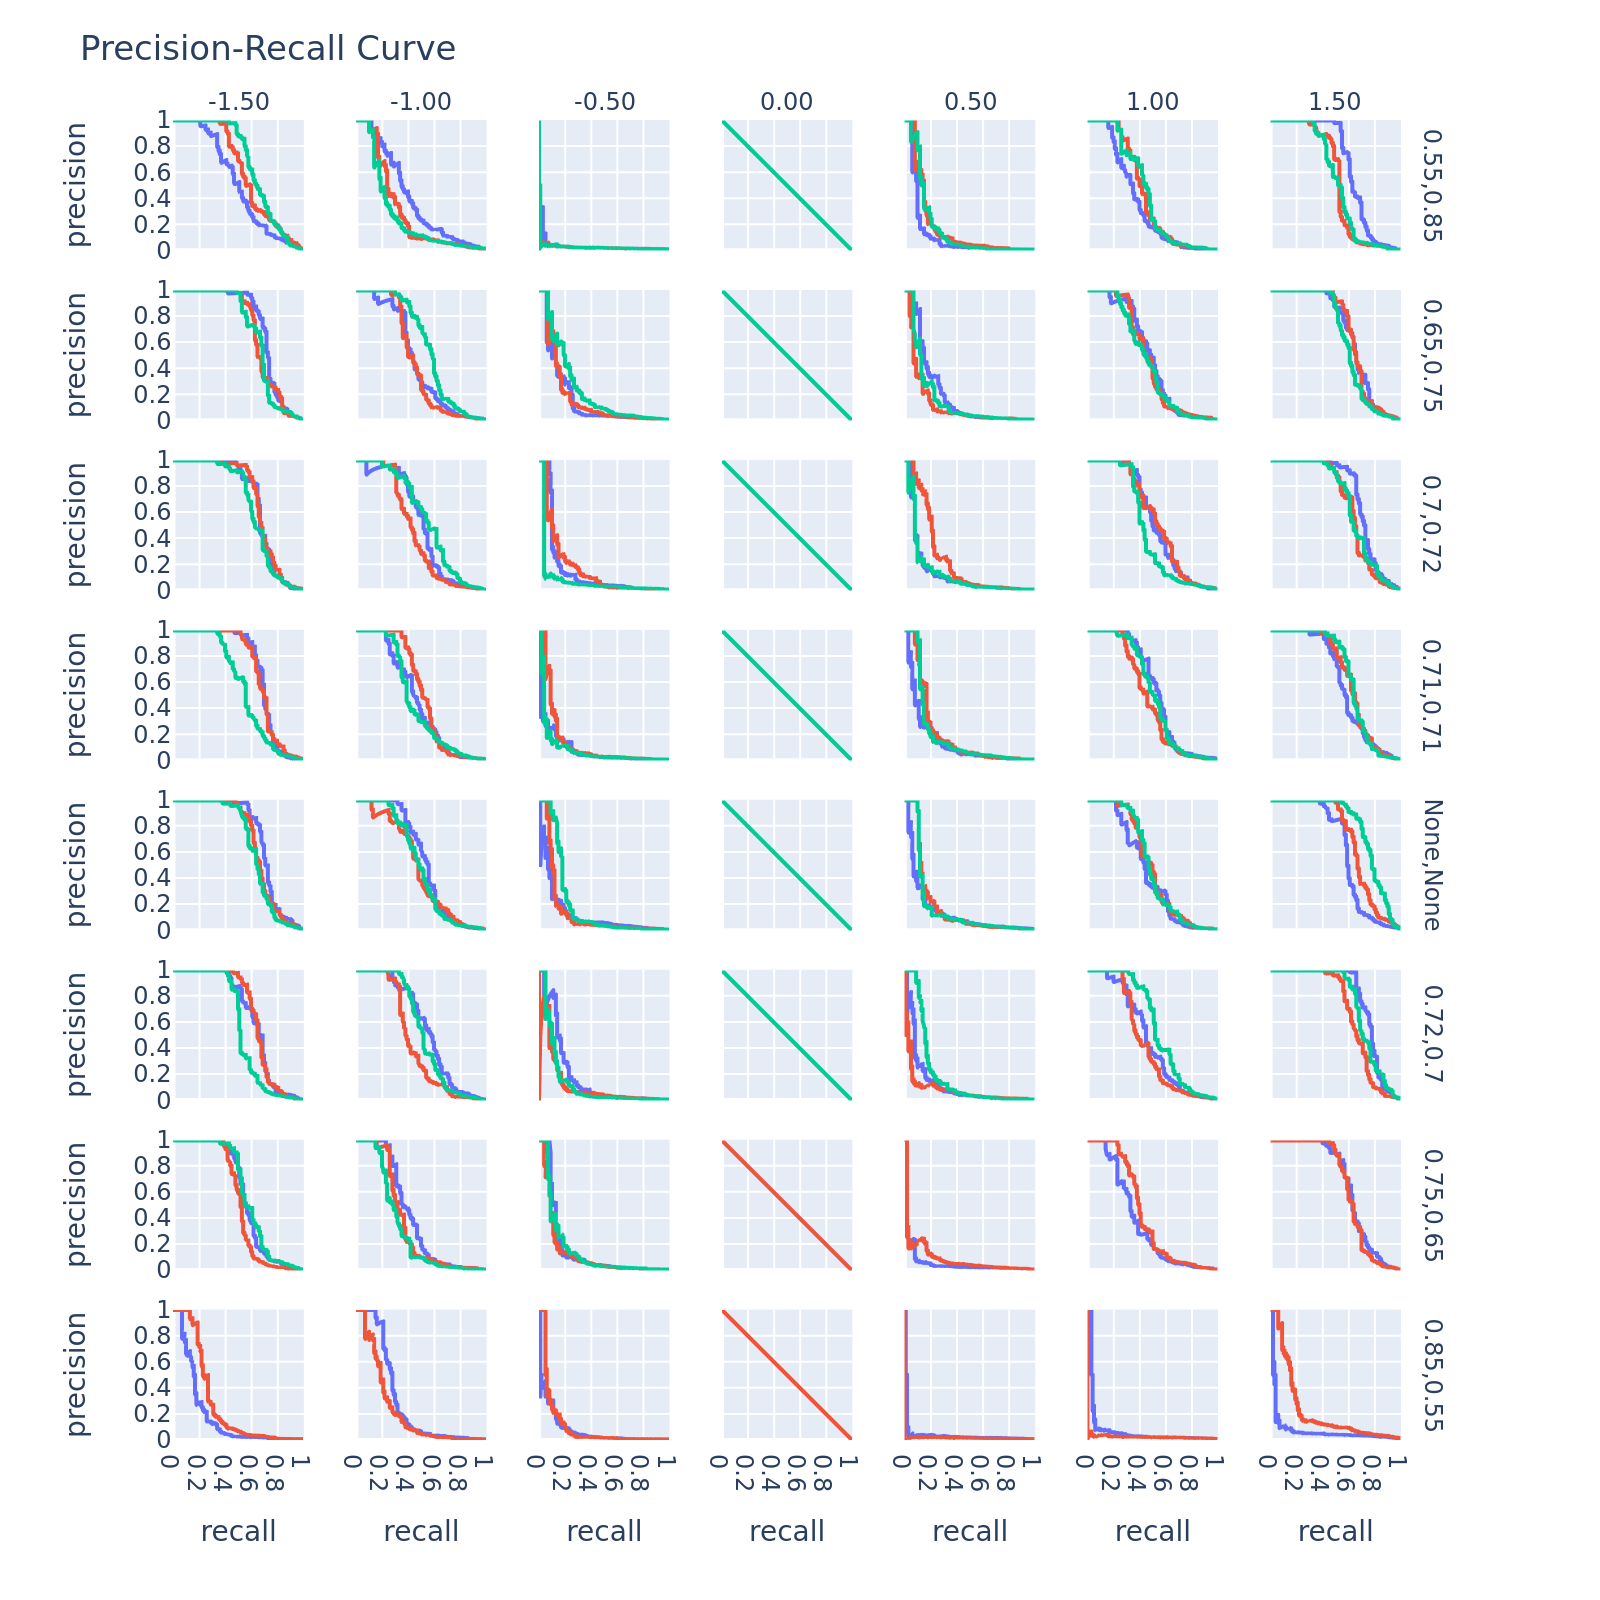

In [18]:
fig = extras.plot_precision_recall_curve(df_prc_curves)
fig.update_layout(width=800, height=800)
fig.show(renderer="png", scale=2)